# Testing generalisation

In [1]:
import rootutils

rootutils.setup_root(
    search_from='.',
    indicator=[".git", "pyproject.toml"],
    project_root_env_var=True, # set the PROJECT_ROOT environment variable to root directory
    dotenv=True, # load environment variables from .env if exists in root directory
    pythonpath=True, # add root directory to the PYTHONPATH (helps with imports)
    cwd=True, # change current working directory to the root directory (helps with filepaths)
)

PosixPath('/home/milton/workspace/lca')

In [2]:
import os
import argparse
from pathlib import Path

import numpy as np
import jax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx
import optax
from tqdm import tqdm
from typing import Callable
from jaxtyping import Array, Float, PyTree

from src.model.lca import AttentionLCA
from src.nn.seeding import init_central_seed
from src.dataset.emojis import EmojiDataset
from src.visualisation.utils import plot_examples
from src.utils/b import seed_everything, save_pytree

In [3]:
rng, jax_key = seed_everything(None)

batch_size = 8
# dataset_path = 'data/datasets/emojis/copy_color_larger_dataset.h5'
dataset_path = 'data/datasets/emojis/copy_color_larger_dataset_no_blue_koala.h5'
dataset = EmojiDataset(dataset_path, batch_size, rng)

print(len(dataset))

10


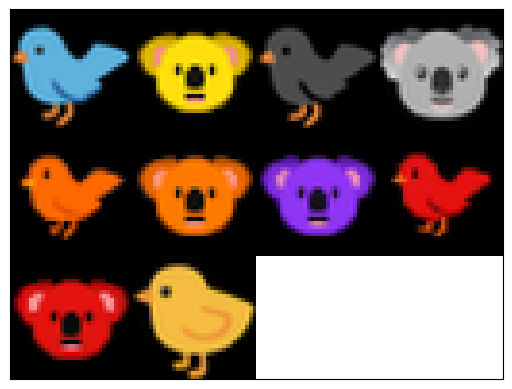

In [4]:
prompt, images = dataset[list(range(10))]
plot_examples(images, w=4, format='NCHW');

In [5]:
import h5py

with h5py.File(dataset_path) as f:
    descriptions = f['descriptions'][:]

print(descriptions)

[[b'blue bird']
 [b'yellow koala']
 [b'gray bird']
 [b'gray koala']
 [b'orange_bird']
 [b'orange_koala']
 [b'purple koala']
 [b'red bird']
 [b'red koala']
 [b'yellow bird']]


# Training results

In [6]:
from src.utils import load_pytree

lca = AttentionLCA(
    token_dim=dataset.token_dim,
    hidden_size=128,
    update_width=dataset.token_dim * 4,
    update_depth=2,
    key=jax_key,
)
lca = load_pytree('data/logs/lca_small_dataset/checkpoint.eqx', lca)
lca = load_pytree('data/logs/lca_small_dataset_no_koala/checkpoint.eqx', lca)

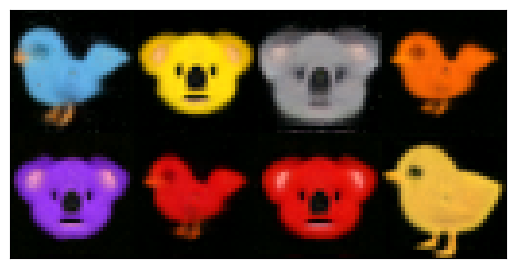

In [7]:
batch = dataset.sample_batch()
output, _ = jax.vmap(lca, in_axes=(None, 0))(init_central_seed((lca.state_size, 32, 32)), batch[0], key=jr.split(jr.key(42), 8))
plot_examples(output.clip(0, 1), w=4, format='NCHW');

# Testing zero-shot generalisation

In [8]:
from transformers import AutoModel, AutoTokenizer
import torch

torch.set_grad_enabled(False)

text_embedding_model = 'openai/clip-vit-base-patch32'

model = AutoModel.from_pretrained(text_embedding_model)
tokenizer = AutoTokenizer.from_pretrained(text_embedding_model)

# prompt = 'purple bird'
prompt = 'blue koala'

encoding = tokenizer(prompt, padding=True, truncation=True, return_tensors="pt")
token_embeddings = model.text_model(
    encoding['input_ids'], output_hidden_states=True
).last_hidden_state.cpu().numpy()

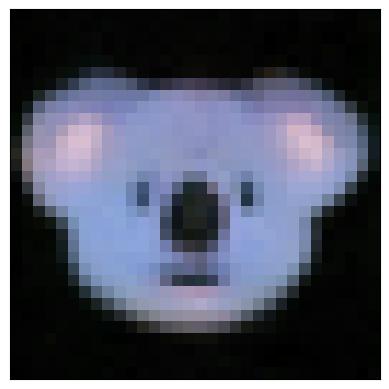

In [9]:
from src.visualisation.dev import plot_state

output, _ = lca(init_central_seed((lca.state_size, 32, 32)), token_embeddings[0], key=jr.key(42))
plot_state(output);